In [2]:
import streamlit as st
from streamlit_option_menu import option_menu
import easyocr
from PIL import Image
import pandas as pd
import numpy as np
import re
import io
import psycopg2

In [3]:
def image_to_text(path):
    input_img=Image.open(path)

    #converting image into array format
    image_arr=np.array(input_img)

    reader=easyocr.Reader(['en'])
    text=reader.readtext(image_arr,detail=0)

    return text, input_img


In [6]:
text_img, input_img=image_to_text(r"C:\Users\Javid Akthar\Desktop\Bizcardx\5.png")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [60]:
text_img

['SANTHOSH',
 'Technical Manager',
 '123 ABC St , Tirupur, TamilNadu;',
 '641603',
 '+123-456-1234',
 'hello@Sun.com',
 'www.Suncom',
 'Sun Electricals']

In [4]:
def extracted_text(texts):
    extra_dict = {"NAME":[], "DESIGNATION":[], "COMPANY_NAME":[], "CONTACT":[], "EMAIL":[], "WEBSITE":[],
                  "ADDRESS":[], "PINCODE":[]}
    extra_dict["NAME"].append(texts[0])
    extra_dict["DESIGNATION"].append(texts[1])

    for i in range(2,len(texts)):

        if texts[i].startswith("+") or texts[i].replace("-","").isdigit() and "-" in texts[i]:
            extra_dict["CONTACT"].append(texts[i])

        elif "@" in texts[i] and ".com" in texts[i]:
            extra_dict["EMAIL"].append(texts[i])

        elif "WWW" in texts[i] or "www" in texts[i] or "Www" in texts[i] or "wWw" in texts[i] or "wwW" in texts[i]:
            small= texts[i].lower()
            extra_dict["WEBSITE"].append(small)

        elif "Tamil Nadu" in texts[i] or "TamilNadu" in texts[i] or texts[i].isdigit():
            extra_dict["PINCODE"].append(texts[i])
        
        elif re.match(r'^[A-Za-z]', texts[i]):
            extra_dict["COMPANY_NAME"].append(texts[i])

        else:
            remove_colon=re.sub(r'[,;]','',texts[i])
            extra_dict["ADDRESS"].append(remove_colon)


    for key,value in extra_dict.items():
        if len(value)>0:
            concadenate=" ".join(value)
            extra_dict[key] = [concadenate]

        else:
            value="NA"
            extra_dict[key] =[value]
           

    return extra_dict

In [7]:
text=extracted_text(text_img)
df=pd.DataFrame(text)
df

,NAME,DESIGNATION,COMPANY_NAME,CONTACT,EMAIL,WEBSITE,ADDRESS,PINCODE
0,SANTHOSH,Technical Manager,Sun Electricals,+123-456-1234,hello@Sun.com,www.suncom,NA,"123 ABC St , Tirupur, TamilNadu; 641603"


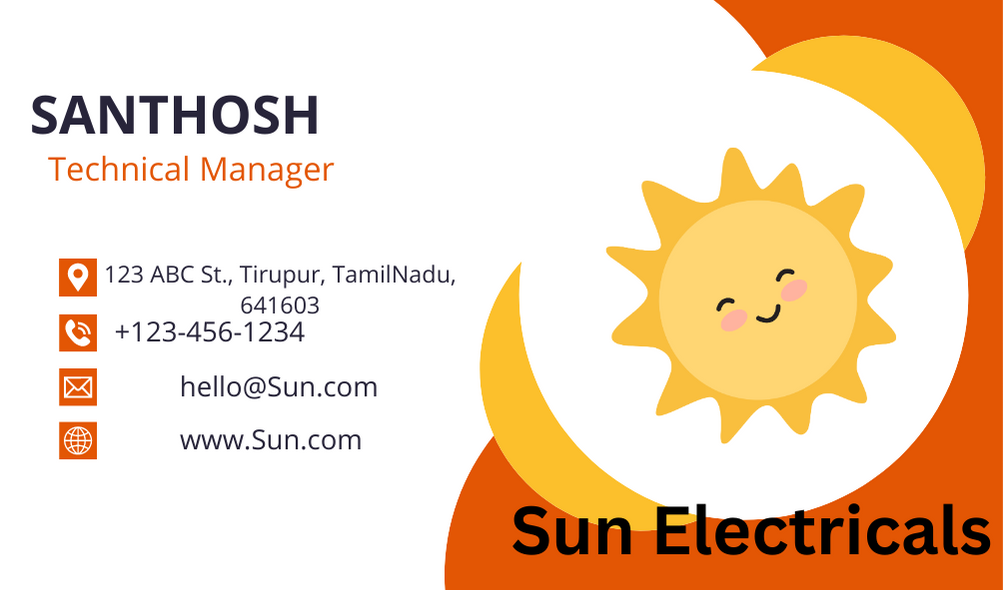

In [71]:
input_img

In [8]:
#converting image into bytes
Image_bytes=io.BytesIO()
input_img.save(Image_bytes, format="PNG")

image_data=Image_bytes.getvalue()

#Creating Dictionary
data={"IMAGE":[image_data]}

df_1=pd.DataFrame(data)

concat_df=pd.concat([df,df_1], axis=1)
concat_df



,NAME,DESIGNATION,COMPANY_NAME,CONTACT,EMAIL,WEBSITE,ADDRESS,PINCODE,IMAGE
0,SANTHOSH,Technical Manager,Sun Electricals,+123-456-1234,hello@Sun.com,www.suncom,NA,"123 ABC St , Tirupur, TamilNadu; 641603",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [18]:
mydb=psycopg2.connect(host="localhost",
                    user="postgres",
                    port=5432,
                    database="Bizcardx_data",
                    password="1234")
cursor=mydb.cursor()

#Table Creation

create_table_query='''CREATE TABLE IF NOT EXISTS bizcard_details(name varchar(255),
                                                                  designation varchar(225),
                                                                  company_name varchar(225),
                                                                  contact varchar(255),
                                                                  email varchar(255),
                                                                  website text,
                                                                  address text,
                                                                  pincode varchar(225),
                                                                  image text)'''

cursor.execute(create_table_query)
mydb.commit()

insert_query='''INSERT INTO bizcard_details(name, designation,company_name,contact,email,website,
                                              address,pincode,image)
                                              
                                              values(%s,%s,%s,%s,%s,%s,%s,%s,%s)'''
                                            

datas=concat_df.values.tolist()[0]
cursor.execute(insert_query,datas)
mydb.commit()

In [19]:
#Select query

select_query="SELECT * FROM bizcard_details"

cursor.execute(select_query)
table=cursor.fetchall()
mydb.commit()

table_df=pd.DataFrame(table, columns=("NAME","DESIGNATION","COMPANY_NAME","CONTACT","EMAIL","WEBSITE",
                                      "ADDRESS","PINCODE","IMAGE"))
table_df

,NAME,DESIGNATION,COMPANY_NAME,CONTACT,EMAIL,WEBSITE,ADDRESS,PINCODE,IMAGE
0,SANTHOSH,Technical Manager,Sun Electricals,+123-456-1234,hello@Sun.com,www.suncom,NA,"123 ABC St , Tirupur, TamilNadu; 641603",\x89504e470d0a1a0a0000000d49484452000003ec0000...


In [21]:
select_query="SELECT NAME FROM bizcard_details"

cursor.execute(select_query)
table_1=cursor.fetchall()
mydb.commit()


name=[]

for i in table_1:
    name.append(i[0])
name

['Amit kumar', 'SANTHOSH']